<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>

</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 1
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [1]:
name = "Zahra Maleki"
studentId = "400110009"

It is recommended to open this notebook in Google Colab from [here](https://colab.research.google.com/drive/1tPrFiVeEtt76GIoImPOuv7NA9hKorlue?usp=sharing) and create a copy. You can comment your questions on the notebook as well.

In this exercise we want to gain hands-on experience with Normalizing Flow Models.
1. We want to implement a simple flow model from scratch. (GPU not required)
2. We will use a flow model to perform image in-painting. (GPU recommended)

# Section 1: Flow From Scratch

In [13]:
# @title imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torchvision as tv
import torch
import torch.nn as nn
import torch.distributions as D



In [14]:
device = torch.device('cpu') # you can change this if you like

One of the challenges in creating flow models is creating invertible transformations. Also we would like it if computation of their inverse and/or the log determinant of their jacobian were simple.

In [15]:
# @title base transform abstract class

class InverseNotAvailable(Exception):
    """Exception to be thrown when a transform does not have an inverse."""

    pass

class Transform(nn.Module):
    """Base class for all transform objects."""

    def forward(self, inputs, context=None):
        raise NotImplementedError()

    def inverse(self, inputs, context=None):
        raise InverseNotAvailable()


First we can create a random permutation transform

In [16]:
class PermutationTransform(Transform):
    def __init__(self, num_features):
        super().__init__()
        permutation = torch.randperm(num_features)
        self.register_buffer('permutation', permutation)
        self.register_buffer('inverse_permutation', torch.argsort(permutation))

    def forward(self, inputs, context=None):
        return inputs[:, self.permutation], 0

    def inverse(self, inputs, context=None):
        return inputs[:, self.inverse_permutation]

Now  lets create a simple Coupling Transform.

In [17]:
class CouplingTransform(Transform):
    def __init__(self, mask, hidden_dims):
        super(CouplingTransform, self).__init__()
        mask = torch.as_tensor(mask, dtype=torch.float32)
        if mask.dim() != 1:
            raise ValueError("Mask must be a 1D tensor.")
        self.register_buffer('mask', mask)

        self.num_features = mask.numel()
        self.num_masked = int(mask.sum().item())
        self.num_condition = self.num_features - self.num_masked

        # s_net and t_net
        self.s_net = self._build_net(self.num_condition, self.num_masked, hidden_dims)
        self.t_net = self._build_net(self.num_condition, self.num_masked, hidden_dims)

        # Initialize s_net last layer to near-zero
        self.s_net[-1].weight.data.zero_()
        self.s_net[-1].bias.data.zero_()

    def _build_net(self, input_dim, output_dim, hidden_dims):
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, output_dim))
        return nn.Sequential(*layers)

    def forward(self, inputs, context=None):
        x_masked = inputs[:, self.mask.bool()]
        x_unmasked = inputs[:, ~self.mask.bool()]

        s = self.s_net(x_unmasked)
        t = self.t_net(x_unmasked)

        y_masked = x_masked * torch.exp(s) + t

        y = inputs.clone()
        y[:, self.mask.bool()] = y_masked

        log_det_J = s.sum(dim=1)
        return y, log_det_J

    def inverse(self, inputs, context=None):
        y_masked = inputs[:, self.mask.bool()]
        y_unmasked = inputs[:, ~self.mask.bool()]

        s = self.s_net(y_unmasked)
        t = self.t_net(y_unmasked)

        x_masked = (y_masked - t) * torch.exp(-s)

        x = inputs.clone()
        x[:, self.mask.bool()] = x_masked
        return x


In this step we want to implement a simple Normalizing Flow Model similar to RealNVP. First we should create our base flow module. This base module is flexible in that it can have any number of transformations that inherit from the base transformation class.

In [18]:
class Flow(nn.Module):
    def __init__(self, transforms, base_distribution=None, device=None):
        super(Flow, self).__init__()
        self.device = device
        self.transforms = nn.ModuleList(transforms).to(self.device)
        self.num_features = self.transforms[0].num_features

        if base_distribution is None:
            self.base_distribution = D.MultivariateNormal(
                loc=torch.zeros(self.num_features, device=self.device),
                covariance_matrix=torch.eye(self.num_features, device=self.device)
            )
        else:
            self.base_distribution = base_distribution

    def forward(self, x):
        log_det_J = 0
        for transform in self.transforms:
            x, log_det = transform(x)
            if torch.isnan(x).any() or torch.isinf(x).any():
                x = torch.nan_to_num(x, nan=0.0, posinf=1e5, neginf=-1e5)
            log_det_J += log_det
        return x, log_det_J

    def log_prob(self, x):
        z, log_det_J = self.forward(x)
        if torch.isnan(z).any() or torch.isinf(z).any():
            raise ValueError("NaN or Inf detected in transformed tensor.")
        log_prob_z = self.base_distribution.log_prob(z.to(self.device))
        return log_prob_z + log_det_J

    def inverse(self, z):
        for transform in reversed(self.transforms):
            z = transform.inverse(z)
        return z

    def sample(self, num_samples):
        z = self.base_distribution.sample((num_samples,)).to(self.device)
        x = self.inverse(z)
        return x

Now  we initialize the model and coupling layers. We then train the model on the simple Moons dataset and visualize its learning process through its latent space.

In [19]:
# Utility function to create alternating masks
def create_alternating_masks(num_features, num_masks):
    masks = []
    for i in range(num_masks):
        mask = [((i + j) % 2) for j in range(num_features)]
        masks.append(mask)
    return masks

In [20]:
# Hyperparameters
num_features = 2
num_layers = 4
hidden_dims = [64, 64]
batch_size = 256
learning_rate = 1e-3
num_epochs = 500

Our flow model can be comprised by CouplingTransforms each followed by a PermutationTransform. You are free to use other architectures or implement other transform as long as they are correct.

You may use a Multivariate Normal distribution.

In [21]:
# Define masks for alternating coupling layers
x_full, _ = make_moons(n_samples=10000, noise=0.1)
x_full = torch.tensor(x_full, dtype=torch.float32).to(device)

# Compute mean and std for standardization
x_mean = x_full.mean(dim=0, keepdim=True)
x_std = x_full.std(dim=0, keepdim=True)

masks = create_alternating_masks(num_features, num_layers)
transforms = []
for i in range(num_layers):
    mask = masks[i]
    transforms.append(CouplingTransform(mask=mask, hidden_dims=hidden_dims))
    transforms.append(PermutationTransform(num_features=num_features))

flow = Flow(transforms=transforms, device=device).to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)


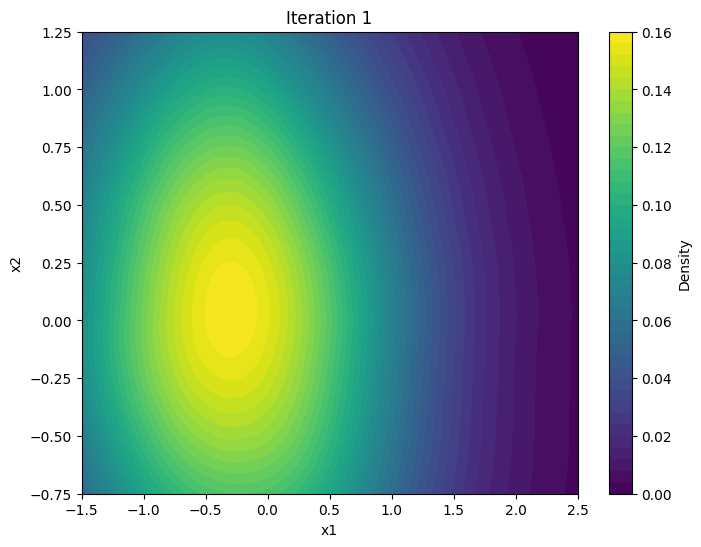

Epoch 50/500, Loss: 2.4863
Epoch 100/500, Loss: 2.3285
Epoch 150/500, Loss: 2.2517


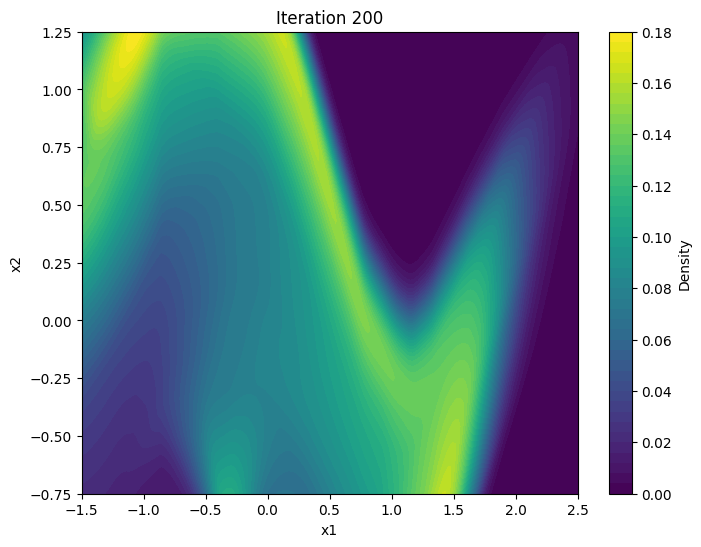

Epoch 200/500, Loss: 2.2244
Epoch 250/500, Loss: 2.1875
Epoch 300/500, Loss: 2.1364
Epoch 350/500, Loss: 2.1265


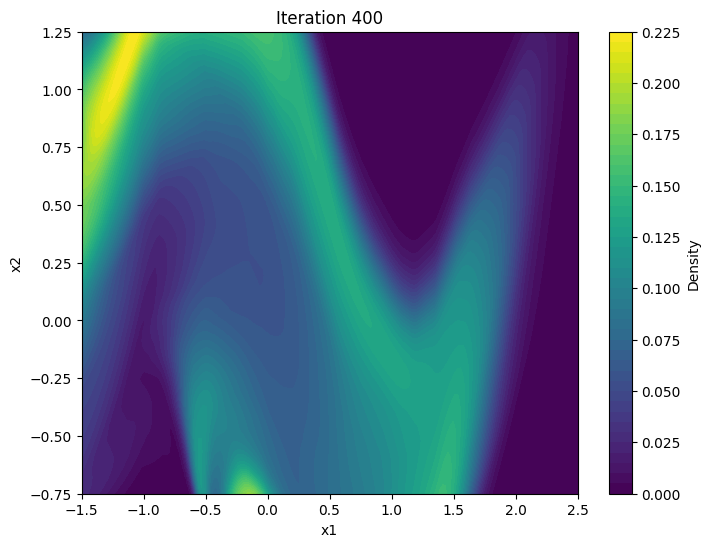

Epoch 400/500, Loss: 2.1193
Epoch 450/500, Loss: 2.1155
Epoch 500/500, Loss: 2.0719


In [22]:
for epoch in range(1, num_epochs + 1):
    x, _ = make_moons(n_samples=batch_size, noise=0.1)
    x = torch.tensor(x, dtype=torch.float32).to(device)

    # Standardize data
    x_std_ = (x - x_mean) / x_std

    optimizer.zero_grad()
    log_prob = flow.log_prob(x_std_)
    loss = -log_prob.mean()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=5.0)
    optimizer.step()

    # Visualization of the learned density every 200 epochs or at epoch 1
    if epoch % 200 == 0 or epoch == 1:
        with torch.no_grad():
            # Create a grid of points
            xline = torch.linspace(-1.5, 2.5, 200, device=device)
            yline = torch.linspace(-0.75, 1.25, 200, device=device)
            xgrid, ygrid = torch.meshgrid(xline, yline, indexing='ij')
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1).to(device)

            # Compute log-probability for each point in the grid
            try:
                log_prob_grid = flow.log_prob(xyinput)
                # Handle NaN values in log probabilities
                log_prob_grid = torch.nan_to_num(log_prob_grid, nan=-1e10)
                # Exponentiate log-probability to get the density
                density_grid = torch.exp(log_prob_grid).reshape(200, 200).cpu()
            except ValueError as e:
                print(f"ValueError during visualization at epoch {epoch}: {e}")
                continue

        # Plot the density
        plt.figure(figsize=(8, 6))
        plt.contourf(
            xgrid.cpu().numpy(),
            ygrid.cpu().numpy(),
            density_grid.numpy(),
            levels=50,
            cmap='viridis'
        )
        plt.title(f'Iteration {epoch}')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.colorbar(label='Density')
        plt.show()

    # Optional: Print loss every 50 epochs
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}")

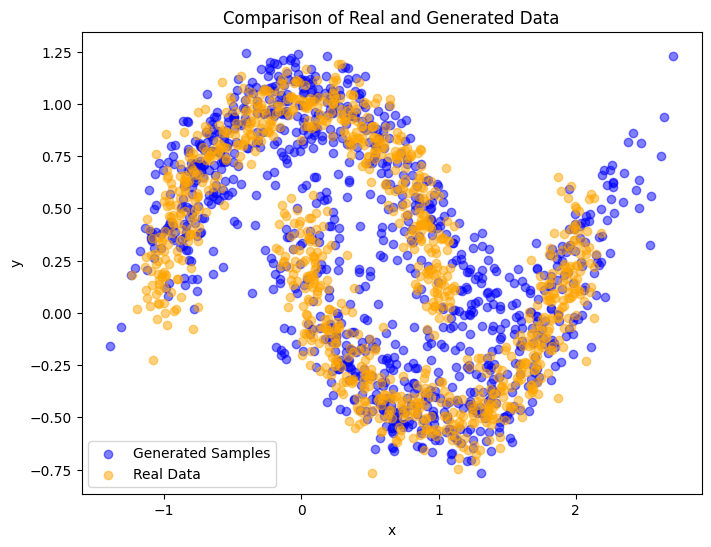

In [23]:
# Sampling from the flow
with torch.no_grad():
    samples_std = flow.sample(1000)  # samples in standardized space
    # Inverse standardization
    samples = samples_std * x_std + x_mean
    samples = samples.cpu().numpy()

x_real, _ = make_moons(1000, noise=0.1)

# Compare distributions
plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label='Generated Samples', color='blue')
plt.scatter(x_real[:, 0], x_real[:, 1], alpha=0.5, label='Real Data', color='orange')
plt.legend()
plt.title('Comparison of Real and Generated Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Section 2:Flows In Action

Here, we show how a flow can be trained to generate images with the `normflows` package. The flow is a [Glow](https://arxiv.org/abs/1807.03039) model, which is based on the [multi-scale architecture](https://arxiv.org/abs/1605.08803). This Glow model is applied to the MNIST dataset.

## Perparation

To get started, we have to install the `normflows` package.

In [53]:
# Import required packages
import torch
import torchvision as tv
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm
import os

Glow consists of `nf.flows.GlowBlocks`, that are arranged in a `nf.MultiscaleFlow`, following the multi-scale architecture. The base distribution is a `nf.distributions.DiagGaussian`, which is a diagonal Gaussian.

In [54]:
# Define the directory to save checkpoints
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)


In [76]:
# Set up model (nothing TODO here)

# Define flows
L = 2
K = 16
torch.manual_seed(0)

input_shape = (1, 28, 28)
n_dims = np.prod(input_shape)
channels = 1
hidden_channels = 128
split_mode = 'channel'
scale = True

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                     split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i),
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L,
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.DiagGaussian(latent_shape)]

# Construct flow model with the multiscale architecture
model = nf.MultiscaleFlow(q0, flows, merges)

model.to(device)

MultiscaleFlow(
  (q0): ModuleList(
    (0-1): 2 x DiagGaussian()
  )
  (flows): ModuleList(
    (0): ModuleList(
      (0-15): 16 x GlowBlock(
        (flows): ModuleList(
          (0): AffineCouplingBlock(
            (flows): ModuleList(
              (0): Split()
              (1): AffineCoupling(
                (param_map): ConvNet2d(
                  (net): Sequential(
                    (0): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                    (1): LeakyReLU(negative_slope=0.0)
                    (2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
                    (3): LeakyReLU(negative_slope=0.0)
                    (4): Conv2d(128, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                  )
                )
              )
              (2): Merge()
            )
          )
          (1): Invertible1x1Conv()
          (2): ActNorm()
        )
      )
      (16): Squeeze()
    )
    (1): ModuleList(
      (0-15): 16

In [77]:
# @title loading MNIST dataset with TorchVision

batch_size = 128

transform = tv.transforms.Compose([tv.transforms.ToTensor(),
                                  #  nf.utils.Scale(255. / 256.),
                                   nf.utils.Jitter(1 / 256.)])

train_data = tv.datasets.MNIST('datasets/', train=True,
                                 download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,
                                           drop_last=True)

test_data = tv.datasets.MNIST('datasets/', train=False,
                                download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## Training

Now, can train the model on the image data. you can change this code to your prefered style as long as it is correct and the result is reasonable.

In [78]:
# Train model
max_iter = 10000
save_every = 2000  # Save every 2000 iterations

loss_hist = np.array([])

optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_iter = iter(train_loader)

for i in tqdm(range(max_iter)):
## TODO training loop ( hint: use model.forward_kld(x), gives the log prob  )
    try:

        x, _ = next(train_iter)
    except StopIteration:

        train_iter = iter(train_loader)
        x, _ = next(train_iter)

    x = x.to(device)

    loss = model.forward_kld(x)  # KL Divergence loss


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())

    if (i + 1) % save_every == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'model_iter_{i+1}.pth')
        torch.save({
            'iteration': i + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_hist': loss_hist,
        }, checkpoint_path)
        print(f'Checkpoint saved at iteration {i+1} to {checkpoint_path}')


 20%|██        | 201/1000 [00:33<02:23,  5.59it/s]

Checkpoint saved at iteration 200 to checkpoints\model_iter_200.pth


 40%|████      | 401/1000 [01:06<01:45,  5.67it/s]

Checkpoint saved at iteration 400 to checkpoints\model_iter_400.pth


 60%|██████    | 601/1000 [01:39<01:12,  5.48it/s]

Checkpoint saved at iteration 600 to checkpoints\model_iter_600.pth


 80%|████████  | 801/1000 [02:11<00:34,  5.72it/s]

Checkpoint saved at iteration 800 to checkpoints\model_iter_800.pth


100%|██████████| 1000/1000 [02:43<00:00,  6.11it/s]

Checkpoint saved at iteration 1000 to checkpoints\model_iter_1000.pth


In [79]:
# Save the final model after training
final_checkpoint_path = os.path.join(checkpoint_dir, 'model_final.pth')
torch.save({
    'iteration': max_iter,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_hist': loss_hist,
}, final_checkpoint_path)
print(f'Final model saved to {final_checkpoint_path}')

Final model saved to checkpoints\model_final.pth


In [ ]:
final_checkpoint_path = os.path.join("C:\\Users\\ASUS\\Downloads", 'model_final.pth')

final_checkpoint_path = 'model_final.pth'

checkpoint = torch.load(final_checkpoint_path)

model = nf.MultiscaleFlow(q0, flows, merges)
model = model.to(device)

optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

loss_hist = checkpoint['loss_hist']
iteration = checkpoint['iteration']

print(f"Model loaded successfully from {final_checkpoint_path}")
print(f"Last saved iteration: {iteration}")


Model loaded successfully from model_final_1.pth
Last saved iteration: 10000


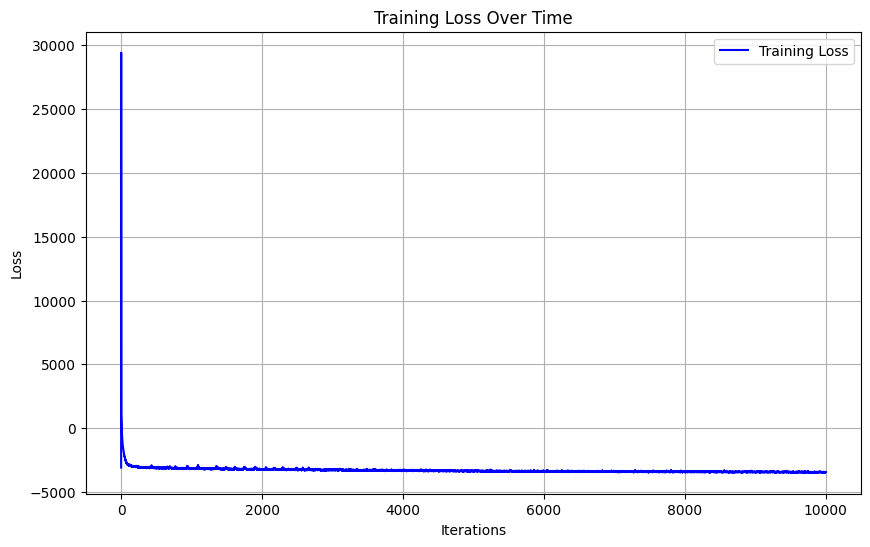

In [84]:
# TODO Plot training loss

plt.figure(figsize=(10, 6))
plt.plot(loss_hist, label='Training Loss', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

To evaluate our model, we can just draw samples from our model.

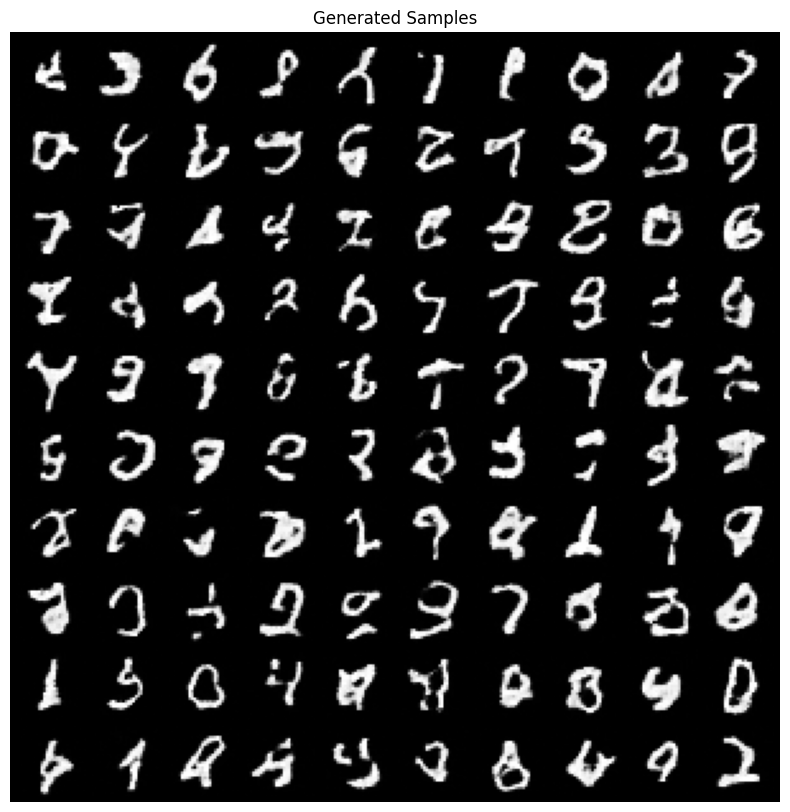

In [85]:
# Model samples
num_samples_per_grid = 10  # Number of samples per grid row
total_samples = num_samples_per_grid * num_samples_per_grid  # Total samples to generate


with torch.no_grad():
    # Sample from the base distribution
    x, _ = model.sample(num_samples_per_grid ** 2)  # No class labels needed
    x_ = torch.clamp(x, 0, 1)

    # Arrange samples in a grid
    grid = tv.utils.make_grid(x_, nrow=num_samples_per_grid)

    # Plot the grid of samples
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title('Generated Samples')
    plt.show()

Note that to get competitive performance, a much larger model than specified in this notebook, which is trained over more iterations, is needed.

## In-Painting

In [86]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as TF
import torch.optim as optim

Now you are supposed to create a function that masks a random square of the image, and a function that fills the missing part based on maximum liklihood using the trained flow model.

In [87]:
def apply_random_square_mask(image, mask_size=8):
    """
    Applies a random square mask to the input image.

    Args:
        image (torch.Tensor): Input image tensor of shape [C, H, W].
        mask_size (int): Size of the square mask.

    Returns:
        masked_image (torch.Tensor): Image with the masked square.
        mask (torch.Tensor): Binary mask indicating masked regions (1 for masked).
    """
    _, H, W = image.shape
    masked_image = image.clone()
    mask = torch.zeros_like(image[0])  # Single channel mask

    # Ensure the mask can fit within the image dimensions
    max_x = H - mask_size
    max_y = W - mask_size

    # Sample random top-left corner for the square mask
    top_left_x = random.randint(0, max_x)
    top_left_y = random.randint(0, max_y)

    # Apply the mask (set the region to 0)
    masked_image[:, top_left_x:top_left_x + mask_size, top_left_y:top_left_y + mask_size] = 0
    mask[top_left_x:top_left_x + mask_size, top_left_y:top_left_y + mask_size] = 1.0  # Mark the masked area

    return masked_image, mask

def apply_random_noise_mask(image, noise_fraction=0.1):
    """
    Applies a random noise mask to the input image.

    Args:
        image (torch.Tensor): Input image tensor of shape [C, H, W].
        noise_fraction (float): Fraction of pixels to replace with noise.

    Returns:
        masked_image (torch.Tensor): Image with noise added.
        mask (torch.Tensor): Binary mask indicating noise regions (1 for noise).
    """
    masked_image = image.clone()
    mask = torch.zeros_like(image[0])  # Single channel mask

    C, H, W = image.shape
    num_pixels = H * W
    num_noise = int(noise_fraction * num_pixels)

    # Random indices
    noise_indices = np.random.choice(num_pixels, num_noise, replace=False)
    noise_coords = np.unravel_index(noise_indices, (H, W))

    # Apply noise
    for c in range(C):
        noise = torch.rand(num_noise) * 2 - 1  # Random noise in [-1, 1]
        masked_image[c, noise_coords[0], noise_coords[1]] = noise
    mask[noise_coords[0], noise_coords[1]] = 1.0

    return masked_image, mask


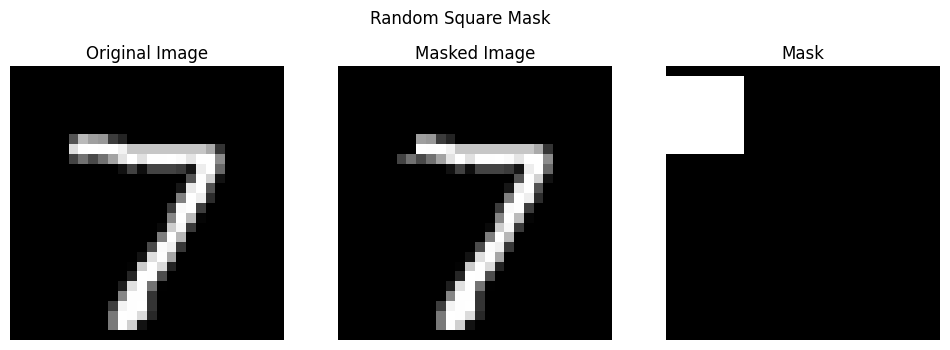

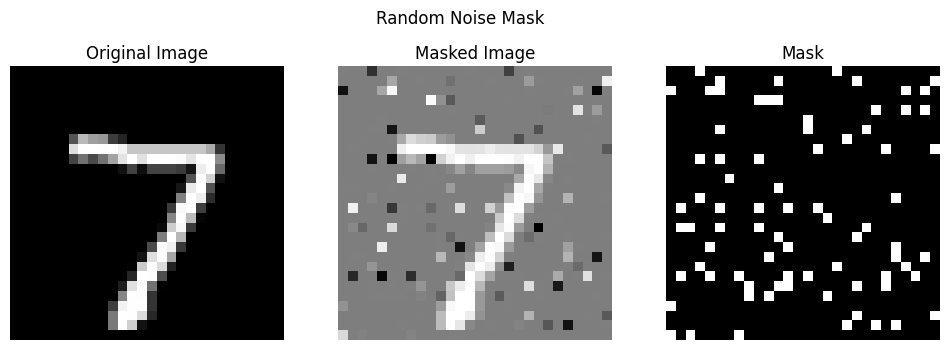

In [92]:
def visualize_masking(original_image, masked_image, mask, title="Masking Example"):
    """
    Visualizes the original, masked images and the mask.

    Args:
        original_image (torch.Tensor): Original image tensor [C, H, W].
        masked_image (torch.Tensor): Masked image tensor [C, H, W].
        mask (torch.Tensor): Binary mask [H, W].
        title (str): Title for the plot.
    """
    original = original_image.squeeze().cpu().numpy()
    masked = masked_image.squeeze().cpu().numpy()
    mask_display = mask.cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(masked, cmap='gray')
    axs[1].set_title("Masked Image")
    axs[1].axis('off')

    axs[2].imshow(mask_display, cmap='gray')
    axs[2].set_title("Mask")
    axs[2].axis('off')

    plt.suptitle(title)
    plt.show()

def visualize_batch_inpainting(originals, masked, inpainted, masks, title="Batch Inpainting Results"):
    """
    Visualizes a batch of original, masked, and inpainted images with their masks.

    Args:
        originals (torch.Tensor): Original images [N, C, H, W].
        masked (torch.Tensor): Masked images [N, C, H, W].
        inpainted (torch.Tensor): Inpainted images [N, C, H, W].
        masks (torch.Tensor): Masks [N, H, W].
        title (str): Title for the plot.
    """
    N = originals.size(0)
    fig, axs = plt.subplots(N, 4, figsize=(16, 4 * N))

    for i in range(N):
        original = originals[i].squeeze().cpu().numpy()
        masked_img = masked[i].squeeze().cpu().numpy()
        inpainted_img = inpainted[i].squeeze().cpu().numpy()
        mask_display = masks[i].cpu().numpy()

        axs[i, 0].imshow(original, cmap='gray')
        axs[i, 0].set_title("Original")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(masked_img, cmap='gray')
        axs[i, 1].set_title("Masked")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(inpainted_img, cmap='gray')
        axs[i, 2].set_title("Inpainted")
        axs[i, 2].axis('off')

        axs[i, 3].imshow(mask_display, cmap='gray')
        axs[i, 3].set_title("Mask")
        axs[i, 3].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Example usage
sample_image, _ = next(iter(test_loader))
sample_image = sample_image[0]  # Take the first image

# Apply random square mask
masked_image_square, mask_square = apply_random_square_mask(sample_image, mask_size=8)
visualize_masking(sample_image, masked_image_square, mask_square, title="Random Square Mask")

# Apply random noise mask
masked_image_noise, mask_noise = apply_random_noise_mask(sample_image, noise_fraction=0.1)
visualize_masking(sample_image, masked_image_noise, mask_noise, title="Random Noise Mask")


In [96]:
def inpaint_image(model, masked_image, mask, device, num_steps=1000, lr=0.1):
    model.eval()  # Set model to evaluation mode

    masked_image = masked_image.to(device)
    mask = mask.to(device)

    inpainted_image = masked_image.clone().unsqueeze(0)
    mask = mask.unsqueeze(0).unsqueeze(0)

    missing_pixels = torch.zeros_like(masked_image).to(device)
    missing_pixels = torch.nn.Parameter(missing_pixels)
    optimizer = optim.Adam([missing_pixels], lr=lr)

    for step in tqdm(range(num_steps), desc="Inpainting"):
        optimizer.zero_grad()

        full_image = masked_image * (1 - mask) + missing_pixels * mask

        log_prob = model.forward_kld(full_image)

        if torch.isnan(log_prob).any():
            # print(f"NaN detected in log_prob at step {step}")
            break

        if log_prob.dim() == 0:
            loss = -log_prob
        else:
            loss = -log_prob.mean()

        if torch.isnan(loss).any():
            # print(f"NaN detected in loss at step {step}")
            break

        loss.backward()

        torch.nn.utils.clip_grad_norm_([missing_pixels], max_norm=1.0)

        optimizer.step()

        with torch.no_grad():
            missing_pixels.data = torch.clamp(missing_pixels.data, 0, 1)

        if (step + 1) % 100 == 0:
            print(f"Step [{step+1}/{num_steps}], Loss: {loss.item():.4f}")

    inpainted_image = masked_image * (1 - mask) + missing_pixels * mask
    return inpainted_image.squeeze(0)  # Remove the batch dimension and return



In [ ]:
# Example usage with a batch of 4 images
batch_size = 4
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images[:batch_size]
sample_labels = sample_labels[:batch_size]

# Apply random square masks to the batch
masked_images = []
masks = []
inpainted_images = []

for img in sample_images:
    masked_img, mask = apply_random_square_mask(img, mask_size=8)
    masked_images.append(masked_img)
    masks.append(mask)
    inpainted_images.append(inpaint_image(model, masked_img, mask, device, num_steps=1000, lr=0.001))

masked_images = torch.stack(masked_images)
masks = torch.stack(masks)
inpainted_images = torch.stack(inpainted_images)

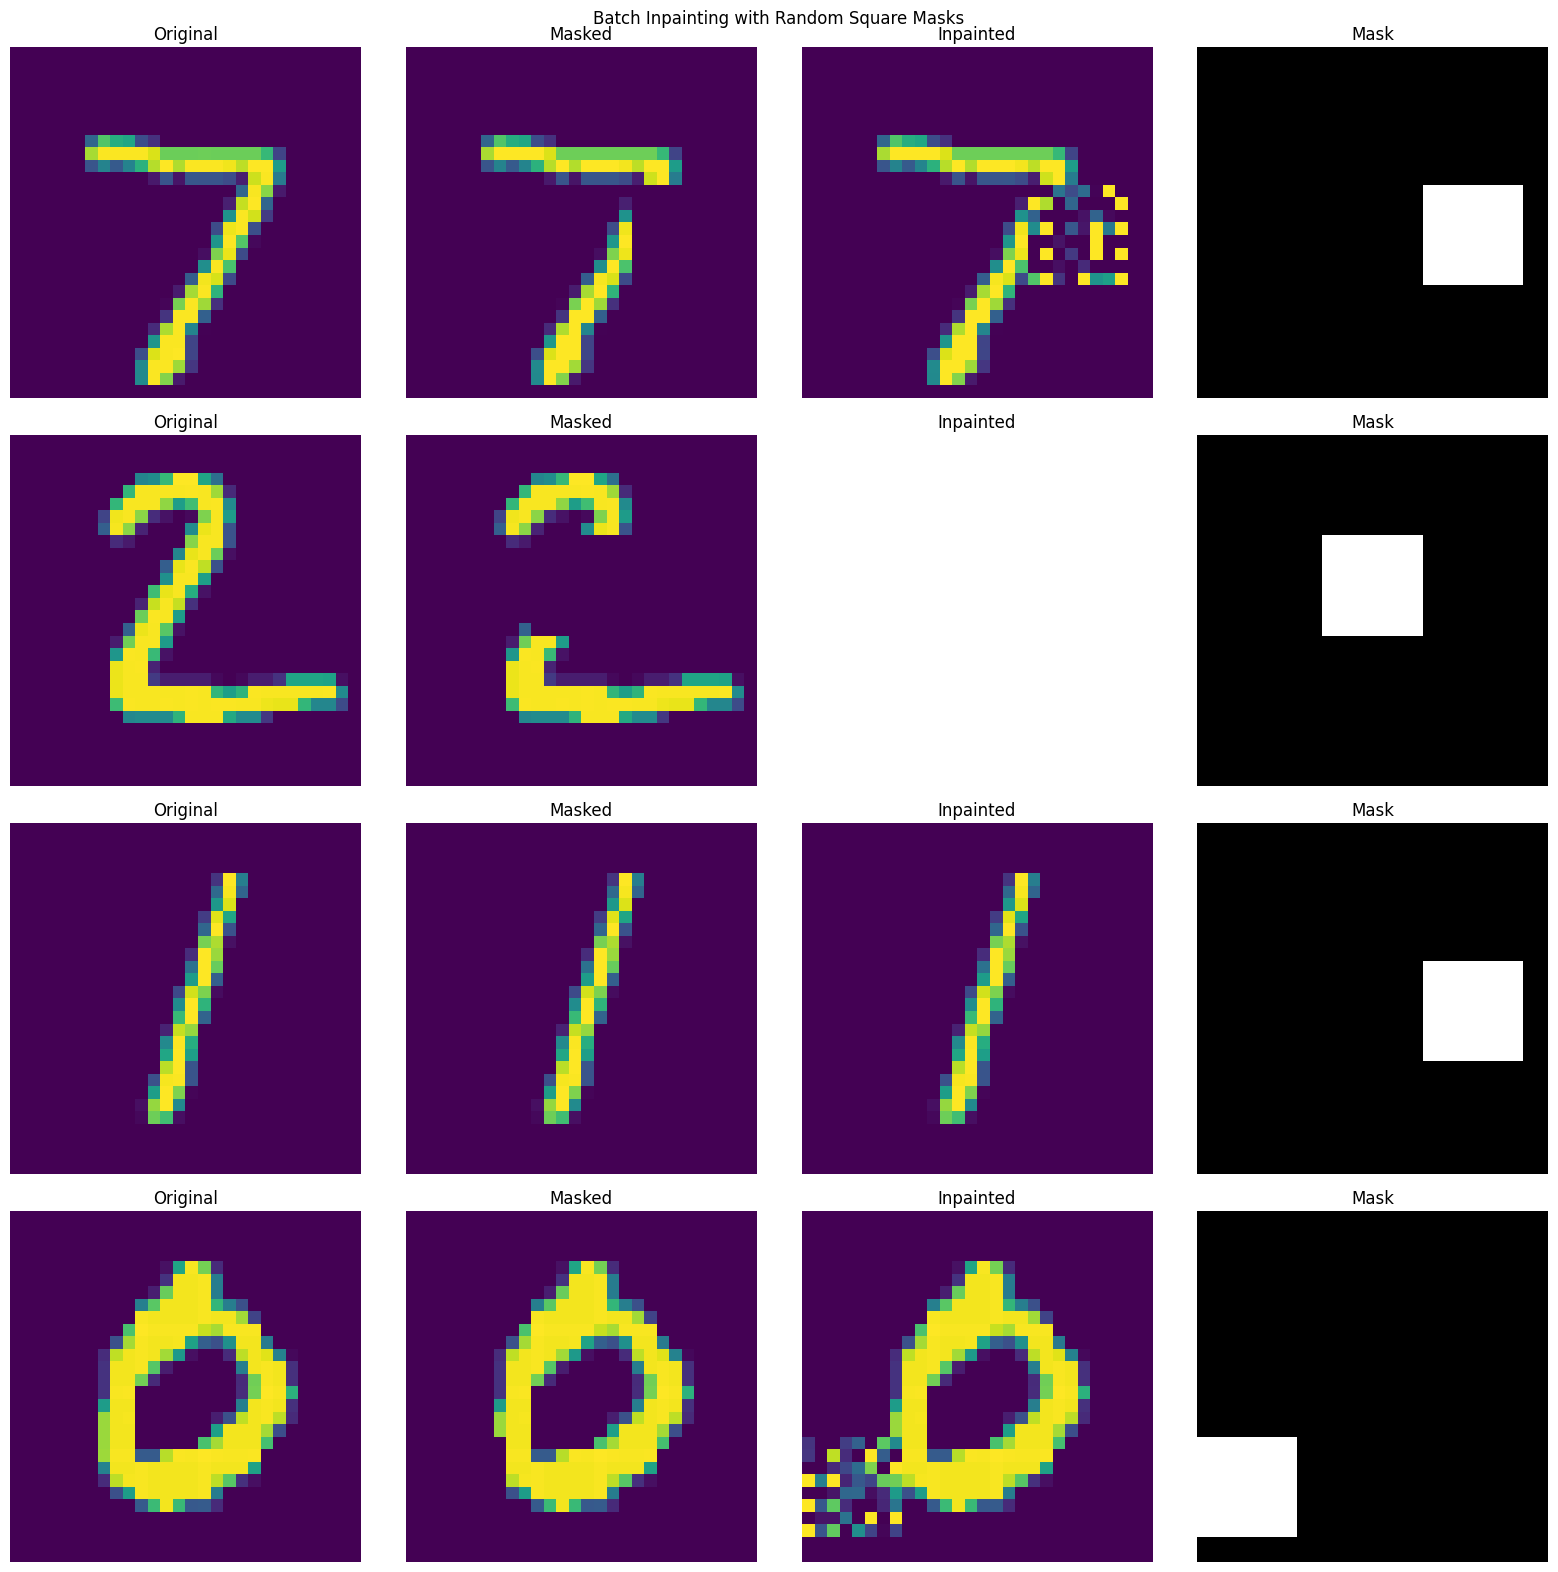

In [38]:
# Visualize the results (this is a suggested code, you can change this)
def visualize_batch_inpainting(originals, masked, inpainted, masks, title="Batch Inpainting Results"):
    """
    Visualizes a batch of original, masked, and inpainted images with their masks.

    Args:
        originals (torch.Tensor): Original images [N, C, H, W].
        masked (torch.Tensor): Masked images [N, C, H, W].
        inpainted (torch.Tensor): Inpainted images [N, C, H, W].
        masks (torch.Tensor): Masks [N, H, W].
        title (str): Title for the plot.
    """
    N = originals.size(0)
    fig, axs = plt.subplots(N, 4, figsize=(16, 4 * N))

    for i in range(N):

        original = originals[i].permute(1, 2, 0).detach().cpu().numpy()
        masked_img = masked[i].permute(1, 2, 0).detach().cpu().numpy()
        inpainted_img = inpainted[i].permute(1, 2, 0).detach().cpu().numpy()
        mask_display = masks[i].detach().cpu().numpy()

        axs[i, 0].imshow(original)
        axs[i, 0].set_title("Original")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(masked_img)
        axs[i, 1].set_title("Masked")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(inpainted_img)
        axs[i, 2].set_title("Inpainted")
        axs[i, 2].axis('off')

        axs[i, 3].imshow(mask_display, cmap='gray')
        axs[i, 3].set_title("Mask")
        axs[i, 3].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_batch_inpainting(sample_images, masked_images, inpainted_images, masks, title="Batch Inpainting with Random Square Masks")
